# Part III: Time-Series Forecasting using RNN

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torch.autograd import Variable

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

## Step 1. a) Read the dataset

In [2]:
# !unzip individual+household+electric+power+consumption.zip -d energy_consumption

In [3]:
df = pd.read_csv('energy_consumption/household_power_consumption.txt', delimiter=';')

/cvmfs/soft.ccr.buffalo.edu/versions/2023.01/easybuild/software/avx512/Compiler/gcccore/11.2.0/ipython/7.26.0/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### Statistics about the dataset

In [4]:
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


In [6]:
df.isna().sum()

Date                         0
Time                         0
Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64

### Preprocess the dataset

In [7]:
obj_col = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
for cols in obj_col:
  # df[cols] = df[cols].astype('float64')
  df[cols] = pd.to_numeric(df[cols], errors='coerce')

In [8]:
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df['Year'] = df['DateTime'].dt.year
df['Month'] = df['DateTime'].dt.month
df['Day'] = df['DateTime'].dt.day
df['Hour'] = df['DateTime'].dt.hour
df['Minute'] = df['DateTime'].dt.minute


In [9]:
# df = df.groupby(['Date']).mean()
df.set_index(['DateTime'], inplace=True)
df = df.sort_index()

In [10]:
df.drop(['Date', 'Time'], axis=1, inplace=True)

In [11]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Year,Month,Day,Hour,Minute
DateTime,,,,,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2006,12,16,17,24
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2006,12,16,17,25
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,2006,12,16,17,26
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,2006,12,16,17,27
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,2006,12,16,17,28


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-12-11 23:59:00
Data columns (total 12 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
 7   Year                   int64  
 8   Month                  int64  
 9   Day                    int64  
 10  Hour                   int64  
 11  Minute                 int64  
dtypes: float64(7), int64(5)
memory usage: 205.8 MB


In [13]:
df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Year,Month,Day,Hour,Minute
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00,2.008437e+03,6.496155e+00,1.572784e+01,1.150076e+01,2.950017e+01
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00,1.128677e+00,3.438391e+00,8.827209e+00,6.922227e+00,1.731810e+01
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,2.006000e+03,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.007000e+03,4.000000e+00,8.000000e+00,6.000000e+00,1.500000e+01
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.008000e+03,7.000000e+00,1.600000e+01,1.200000e+01,3.000000e+01
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01,2.009000e+03,9.000000e+00,2.300000e+01,1.800000e+01,4.500000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01,2.010000e+03,1.200000e+01,3.100000e+01,2.300000e+01,5.900000e+01


## Step 1. b) Data Visualization

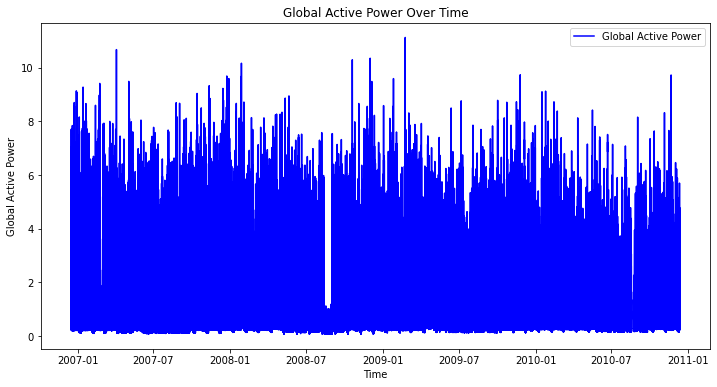

In [14]:
# Data Visualization
# Target feature
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Global_active_power'], label='Global Active Power', color='blue')
plt.title('Global Active Power Over Time')
plt.xlabel('Time')
plt.ylabel('Global Active Power')
plt.legend()
plt.show()

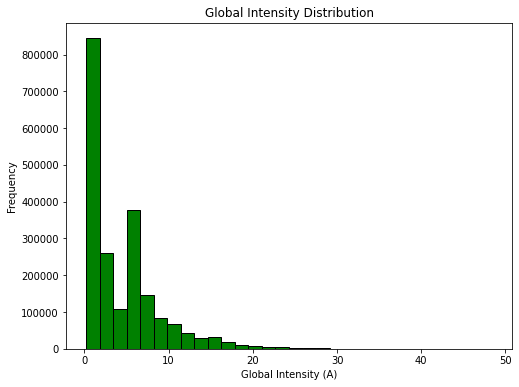

In [15]:
# Global Intensity Distribution
plt.figure(figsize=(8, 6))
plt.hist(df['Global_intensity'], bins=30, color='green', edgecolor='black')
plt.title('Global Intensity Distribution')
plt.xlabel('Global Intensity (A)')
plt.ylabel('Frequency')
plt.show()

In [16]:
# Check for missing values
df.isna().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
Year                         0
Month                        0
Day                          0
Hour                         0
Minute                       0
dtype: int64

In [17]:
df['Global_active_power'].fillna(df['Global_active_power'].mean(), inplace=True)
df['Global_reactive_power'].fillna(df['Global_reactive_power'].mean(), inplace=True)
df['Voltage'].fillna(df['Voltage'].mean(), inplace=True)
df['Global_intensity'].fillna(df['Global_intensity'].mean(), inplace=True)
df['Sub_metering_1'].fillna(df['Sub_metering_1'].mean(), inplace=True)
df['Sub_metering_2'].fillna(df['Sub_metering_2'].mean(), inplace=True)
df['Sub_metering_3'].fillna(df['Sub_metering_3'].mean(), inplace=True)

In [18]:
df.isna().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
Year                     0
Month                    0
Day                      0
Hour                     0
Minute                   0
dtype: int64

In [19]:
# Calculating Power Consumption : Target Variable
df['Power_consumption_every_minute'] = (df['Global_active_power']*1000/60) - (df['Sub_metering_1'] + df['Sub_metering_2'] + df['Sub_metering_3'])
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Year,Month,Day,Hour,Minute,Power_consumption_every_minute
DateTime,,,,,,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2006,12,16,17,24,52.266667
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2006,12,16,17,25,72.333333
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,2006,12,16,17,26,70.566667
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,2006,12,16,17,27,71.800000
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,2006,12,16,17,28,43.100000


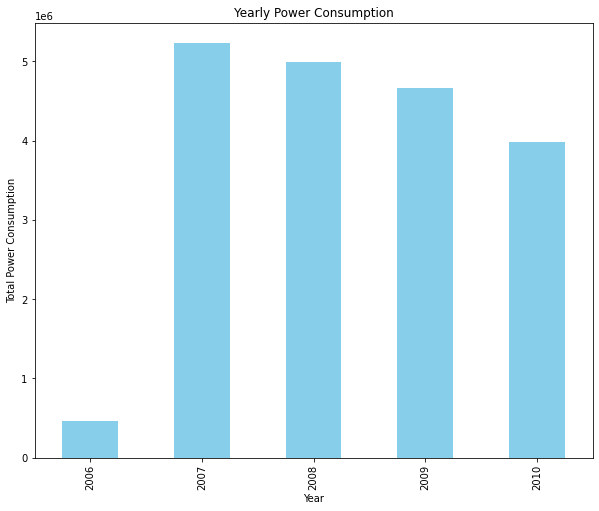

In [20]:
yearly_power_consumption = df.groupby('Year')['Power_consumption_every_minute'].sum()

plt.figure(figsize=(10, 8))

yearly_power_consumption.plot(kind='bar')
yearly_power_consumption.plot(kind='bar', color='skyblue')
plt.title('Yearly Power Consumption')
plt.xlabel('Year')
plt.ylabel('Total Power Consumption')
plt.show()

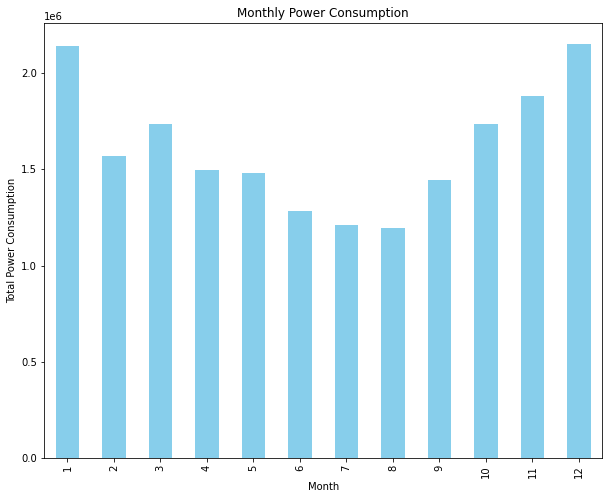

In [21]:
yearly_power_consumption = df.groupby('Month')['Power_consumption_every_minute'].sum()

plt.figure(figsize=(10, 8))

yearly_power_consumption.plot(kind='bar')
yearly_power_consumption.plot(kind='bar', color='skyblue')
plt.title('Monthly Power Consumption')
plt.xlabel('Month')
plt.ylabel('Total Power Consumption')
plt.show()

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-12-11 23:59:00
Data columns (total 13 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   Global_active_power             float64
 1   Global_reactive_power           float64
 2   Voltage                         float64
 3   Global_intensity                float64
 4   Sub_metering_1                  float64
 5   Sub_metering_2                  float64
 6   Sub_metering_3                  float64
 7   Year                            int64  
 8   Month                           int64  
 9   Day                             int64  
 10  Hour                            int64  
 11  Minute                          int64  
 12  Power_consumption_every_minute  float64
dtypes: float64(8), int64(5)
memory usage: 221.7 MB


Text(0.5, 1.0, 'Correlation Matrix')

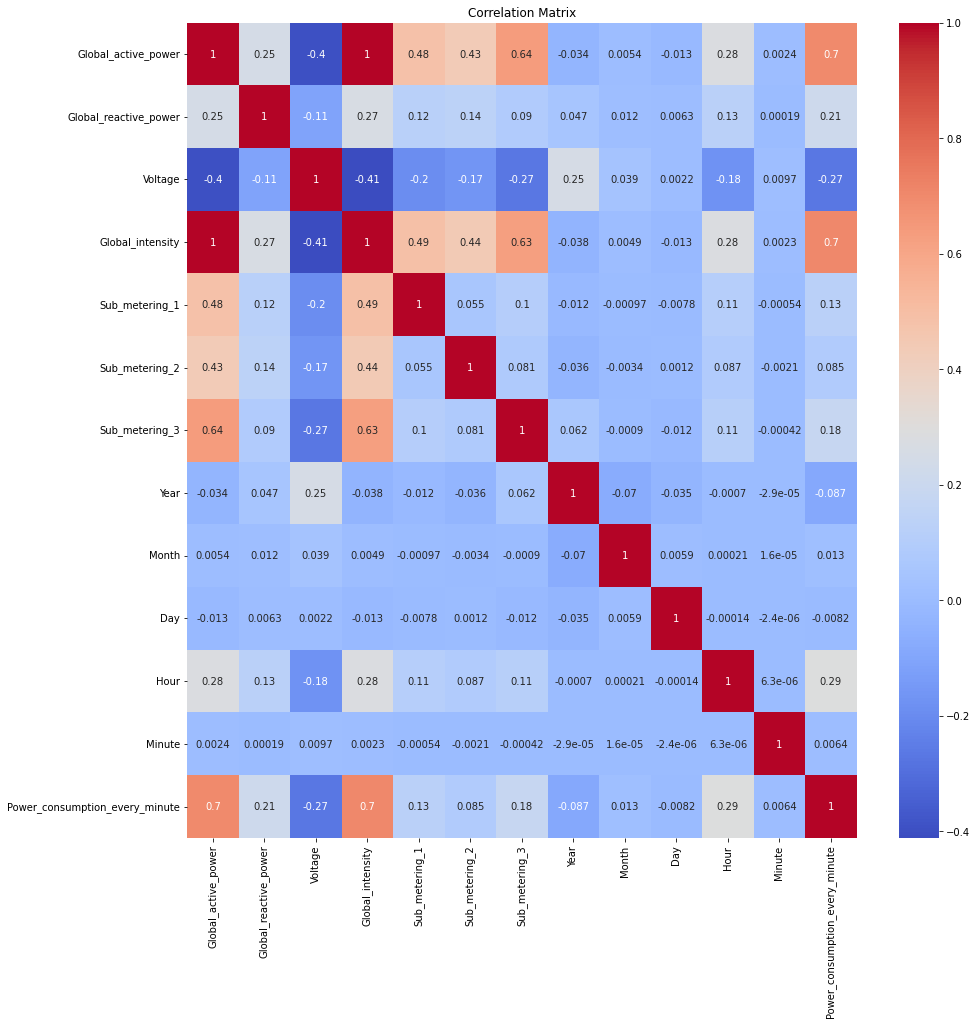

In [23]:
# Correlation Matrix

plt.figure(figsize=(15, 15))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')

In [24]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


## Step 1. c) Dataset preparation

In [25]:
X = df.drop(columns=['Global_active_power', 'Power_consumption_every_minute'], axis=1)
Y = df['Global_active_power']

# Splitting data into training, testing, and validation sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

# Converting Training, testing, and validation dataset into tensors
X_train = torch.tensor(X_train.values, dtype=torch.float32)
Y_train = torch.tensor(Y_train.values, dtype=torch.float32).reshape(-1, 1)

X_test = torch.tensor(X_test.values, dtype=torch.float32)
Y_test = torch.tensor(Y_test.values, dtype=torch.float32).reshape(-1, 1)

X_validation = torch.tensor(X_validation.values, dtype=torch.float32)
Y_validation = torch.tensor(Y_validation.values, dtype=torch.float32).reshape(-1, 1)


In [26]:
print(f'X_train shape: {X_train.shape}')
print(f'Y_train shape: {Y_train.shape}\n')

print(f'X_test shape: {X_test.shape}')
print(f'Y_test shape: {Y_test.shape}\n')

print(f'X_validation shape: {X_validation.shape}' )
print(f'Y_validation shape: {Y_validation.shape}\n')


X_train shape: torch.Size([1680959, 11])
Y_train shape: torch.Size([1680959, 1])

X_test shape: torch.Size([207526, 11])
Y_test shape: torch.Size([207526, 1])

X_validation shape: torch.Size([186774, 11])
Y_validation shape: torch.Size([186774, 1])



In [27]:
batch_size = 1000
train_dataset = torch.utils.data.TensorDataset(X_train, Y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


test_dataset = torch.utils.data.TensorDataset(X_test, Y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


val_dataset = torch.utils.data.TensorDataset(X_validation, Y_validation)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

## Step 2. RNN model architecture

In [28]:
class VanillaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, batch_size):
        super(VanillaRNN, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_size = batch_size

        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initializing hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size,device=x.device).requires_grad_()
        # print(f'h0 shape before: {h0.shape}')
        
        out, h0 = self.rnn(x, h0.detach())
        # print(f'h0 shape after: {h0.shape}')
        
        # Reshape the output
        out = self.fc(out[:, -1, :]) 
        return out

In [29]:
# Hyperparameters
input_size = X_train.shape[1]
hidden_size = 64
num_layers = 3
output_size = 1
learning_rate = 0.001
num_epochs = 5

print(f'Input size: {input_size}')
print(f'Hidden size: {hidden_size}')
print(f'Number of Layers: {num_layers}')
print(f'Output size: {output_size}')

Input size: 11
Hidden size: 64
Number of Layers: 3
Output size: 1


In [30]:
# Initialize the model, loss function, and optimizer
rnn = VanillaRNN(input_size, hidden_size, num_layers, output_size, batch_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate, weight_decay=1e-5)

print(rnn)

VanillaRNN(
  (rnn): RNN(11, 64, num_layers=3, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


## Step 2. b) Train the RNN Model

In [31]:
# Train RNN model

train_losses, train_accuracies = [], []
validation_losses, validation_accuracies = [], []
test_losses, test_accuracies = [], []


val_loss_flag = float('inf')
patience = 4
counter = 0

num_epochs = 20

for epoch in range(num_epochs):
    rnn.train()
    train_loss = 0
    train_r2_sum = 0

    for x_train, y_train in train_loader:
        # Forward pass
        x_train = x_train.view([x_train.shape[0], -1, input_size]).to(device)
        output_train = rnn(x_train)

        # Compute loss
        loss = criterion(output_train, y_train.to(device))

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_r2_sum += r2_score(y_train.cpu().detach().numpy(), output_train.cpu().detach().numpy())
    
    training_loss = train_loss / len(train_loader)
    training_r2_score = train_r2_sum / len(train_loader)
    
    train_losses.append(training_loss)
    train_accuracies.append(training_r2_score*100)
    
    print(f'Epoch [{epoch+1}/{num_epochs}] || Train Loss: {training_loss:.4f} || Train Accuracy: {training_r2_score*100:.3f}%')
    
    with torch.no_grad():
        val_loss = 0
        val_r2_sum = 0
        rnn.eval()
        
        for x_val, y_val in val_loader:
            x_val = x_val.view([x_val.shape[0], -1, input_size]).to(device)
            output_val = rnn(x_val)
            
            val_loss += criterion(output_val, y_val.to(device)).item()
            val_r2_sum += r2_score(y_val.cpu().detach().numpy(), output_val.cpu().detach().numpy())
        
        validation_loss = val_loss / len(val_loader)
        validation_r2_score = val_r2_sum / len(val_loader)
        
        validation_losses.append(validation_loss)
        validation_accuracies.append(validation_r2_score*100)
        
        print(f'\t\tValidation Loss: {validation_loss:.4f} || Validation Accuracy: {validation_r2_score*100:.3f}%')
        
        if validation_loss < val_loss_flag:
            val_loss_flag = validation_loss
            torch.save(rnn.state_dict(), "shivanma_debosmit_assignment1_part_3.pth")
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f"\n Early Stopping at epoch {epoch+1}")
                break

Epoch [1/20] || Train Loss: 0.0660 || Train Accuracy: 94.066%
		Validation Loss: 0.0089 || Validation Accuracy: 99.195%
Epoch [2/20] || Train Loss: 0.0082 || Train Accuracy: 99.259%
		Validation Loss: 0.0048 || Validation Accuracy: 99.567%
Epoch [3/20] || Train Loss: 0.0069 || Train Accuracy: 99.377%
		Validation Loss: 0.0038 || Validation Accuracy: 99.660%
Epoch [4/20] || Train Loss: 0.0107 || Train Accuracy: 99.025%
		Validation Loss: 0.0095 || Validation Accuracy: 99.135%
Epoch [5/20] || Train Loss: 0.0101 || Train Accuracy: 99.089%
		Validation Loss: 0.0421 || Validation Accuracy: 96.150%
Epoch [6/20] || Train Loss: 0.1366 || Train Accuracy: 87.594%
		Validation Loss: 0.1011 || Validation Accuracy: 90.801%
Epoch [7/20] || Train Loss: 0.0308 || Train Accuracy: 97.225%
		Validation Loss: 0.0115 || Validation Accuracy: 98.967%

 Early Stopping at epoch 7


## Test the RNN Model

In [32]:
# Evaluate on the test set

rnn = VanillaRNN(input_size, hidden_size, num_layers, output_size, batch_size).to(device)
rnn.load_state_dict(torch.load("shivanma_debosmit_assignment1_part_3.pth"))

test_losses = []
test_accuracies = []
preds_list = []
targets_list = []

with torch.no_grad():
    rnn.eval()
    test_r2_sum = 0
    t_loss = 0
    
    for x_test, y_test in test_loader:
        x_test = x_test.view([x_test.shape[0], -1, input_size]).to(device)
        y_test = y_test.to(device)
        output_test = rnn(x_test)
        t_loss += criterion(output_test, y_test).item()
        test_r2_sum += r2_score(y_test.cpu().detach().numpy(), output_test.cpu().detach().numpy())
        
        preds_list.extend(output_test.cpu().numpy())
        targets_list.extend(y_test.cpu().numpy())
    
    test_loss = t_loss / len(test_loader)
    test_r2_score = test_r2_sum / len(test_loader)
    
    test_losses.append(test_loss)
    test_accuracies.append(test_r2_score*100)
    
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_r2_score*100:.3f}%')

Test Loss: 0.0037, Test Accuracy: 99.671%


In [33]:
print(f"Training Accuracy: {training_r2_score*100:.4f}, Training Loss: {training_loss:.4f}")
print(f"Validation Accuracy: {validation_r2_score*100:.4f}, Validation Loss: {validation_loss:.4f}")
print(f"Testing Accuracy: {test_r2_score*100:.4f}, Testing Loss: {test_loss:.4f}")

Training Accuracy: 97.2246, Training Loss: 0.0308
Validation Accuracy: 98.9668, Validation Loss: 0.0115
Testing Accuracy: 99.6707, Testing Loss: 0.0037


## Accuracy and Loss plots

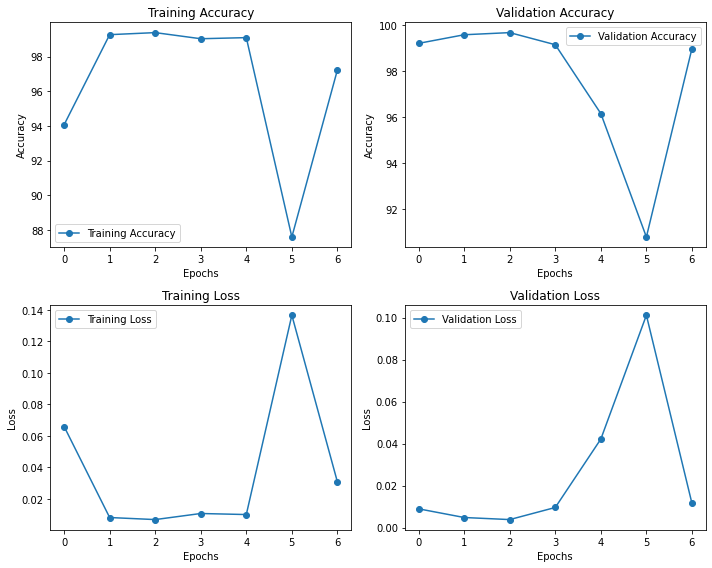

In [34]:
# Plot Training and Validation Accuracy over time (epoch)
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.plot(train_accuracies, label='Training Accuracy', marker='o')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(validation_accuracies, label='Validation Accuracy', marker='o')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Training and Validation Loss over time (epoch)
plt.subplot(2, 2, 3)
plt.plot(train_losses, label='Training Loss', marker='o')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(validation_losses, label='Validation Loss', marker='o')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

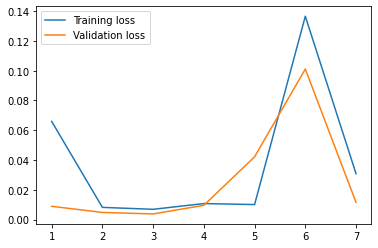

In [35]:
x = np.linspace(1, len(train_losses), len(train_losses))
plt.plot(x, train_losses, scalex=True, label="Training loss")
plt.plot(x, validation_losses, label="Validation loss")
plt.legend()
plt.show()

## Evaluation Metrics

In [36]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(targets_list, preds_list)
mse = mean_squared_error(targets_list, preds_list)
rmse = np.sqrt(mse)
r2 = r2_score(targets_list, preds_list)

print("Mean Absolute Error: {:.4f}".format(mae))
print("Mean Squared Error: {:.4f}".format(mse))
print("R2 Score: {:.4f}".format(r2))

Mean Absolute Error: 0.0363
Mean Squared Error: 0.0037
R2 Score: 0.9967


# Part IV: Sentiment analysis using LSTM

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score

In [ ]:
df = pd.read_csv('Tweets.csv')

df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
df.shape

(14640, 15)

In [ ]:
df['airline_sentiment'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

In [ ]:
df['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [ ]:
df.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


In [ ]:
df.isna()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,False,False,False,True,True,False,True,False,True,False,False,True,False,True,False
1,False,False,False,True,False,False,True,False,True,False,False,True,False,True,False
2,False,False,False,True,True,False,True,False,True,False,False,True,False,False,False
3,False,False,False,False,False,False,True,False,True,False,False,True,False,True,False
4,False,False,False,False,False,False,True,False,True,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,False,False,False,True,False,False,True,False,True,False,False,True,False,True,True
14636,False,False,False,False,False,False,True,False,True,False,False,True,False,False,True
14637,False,False,False,True,True,False,True,False,True,False,False,True,False,False,True
14638,False,False,False,False,False,False,True,False,True,False,False,True,False,False,False


In [ ]:
features = []
for cols in df.columns:
  features.append(cols)

In [ ]:
print(features)

['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence', 'negativereason', 'negativereason_confidence', 'airline', 'airline_sentiment_gold', 'name', 'negativereason_gold', 'retweet_count', 'text', 'tweet_coord', 'tweet_created', 'tweet_location', 'user_timezone']


In [ ]:
df['negativereason'].isna().sum()

5462

In [ ]:
df['negativereason_confidence'].isna().sum()

4118

In [ ]:
df['airline'].unique()

array(['Virgin America', 'United', 'Southwest', 'Delta', 'US Airways',
       'American'], dtype=object)

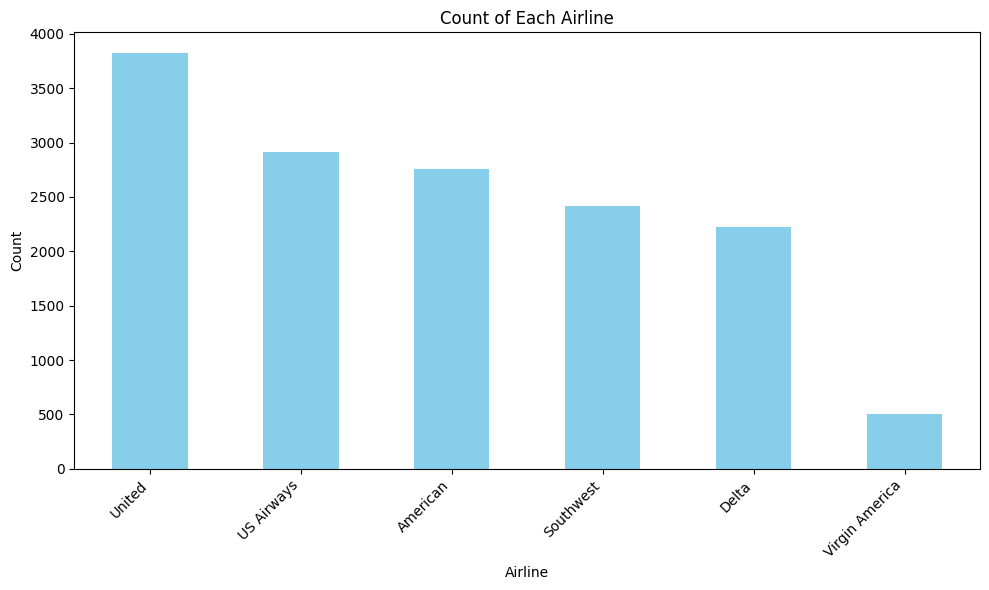

In [8]:
airline_counts = df['airline'].value_counts()

# Plotting the bar graph
plt.figure(figsize=(10, 6))
airline_counts.plot(kind='bar', color='skyblue')
plt.title('Count of Each Airline')
plt.xlabel('Airline')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
df['name'].nunique()

7701

In [ ]:
df['user_timezone'].unique()

array(['Eastern Time (US & Canada)', 'Pacific Time (US & Canada)',
       'Central Time (US & Canada)', 'America/New_York',
       'Atlantic Time (Canada)', 'Quito', nan,
       'Mountain Time (US & Canada)', 'Vienna', 'Caracas', 'Kuala Lumpur',
       'Brisbane', 'Arizona', 'London', 'Tehran', 'Alaska', 'Sydney',
       'Irkutsk', 'Santiago', 'Amsterdam', 'Tijuana', 'Abu Dhabi',
       'Central America', 'Edinburgh', 'Jerusalem', 'Hawaii', 'Paris',
       'Guam', 'New Delhi', 'Stockholm', 'America/Chicago', 'Berlin',
       'Madrid', 'Athens', 'Brussels', 'Taipei', 'Rome', 'Beijing',
       'Mexico City', 'Bern', 'Singapore', 'Indiana (East)', 'Melbourne',
       'Saskatchewan', 'Casablanca', 'Brasilia', 'Kyiv', 'Bucharest',
       'Greenland', 'Prague', 'New Caledonia', 'Bogota', 'Seoul',
       'Sarajevo', 'Wellington', 'Bangkok', 'Warsaw', 'Copenhagen',
       'Hong Kong', 'Guadalajara', 'Mid-Atlantic', 'Mazatlan',
       'Buenos Aires', 'America/Los_Angeles', 'Dublin', 'Lisbon',
 

In [ ]:
# Same time zones: Represented by different names. Eg: Eastern Time (US & Canada),America/New_York, EST

df['user_timezone'] = df['user_timezone'].replace('Eastern Time (US & Canada)', 'EST')
df['user_timezone'] = df['user_timezone'].replace('America/New_York', 'EST')
df['user_timezone'] = df['user_timezone'].replace('America/Detroit', 'EST')
df['user_timezone'] = df['user_timezone'].replace('America/Chicago', 'Pacific Time (US & Canada)')
df['user_timezone'] = df['user_timezone'].replace('America/Los_Angeles', 'Central Time (US & Canada)')
df['user_timezone'] = df['user_timezone'].replace('Arizona', 'Mountain Time (US & Canada)')
df['user_timezone'] = df['user_timezone'].replace('Hongkong', 'Beijing')
# df['user_timezone'] = df['user_timezone'].replace('Arizona', 'Mountain Time (US & Canada)')


In [ ]:
df['user_timezone'].nunique()

79

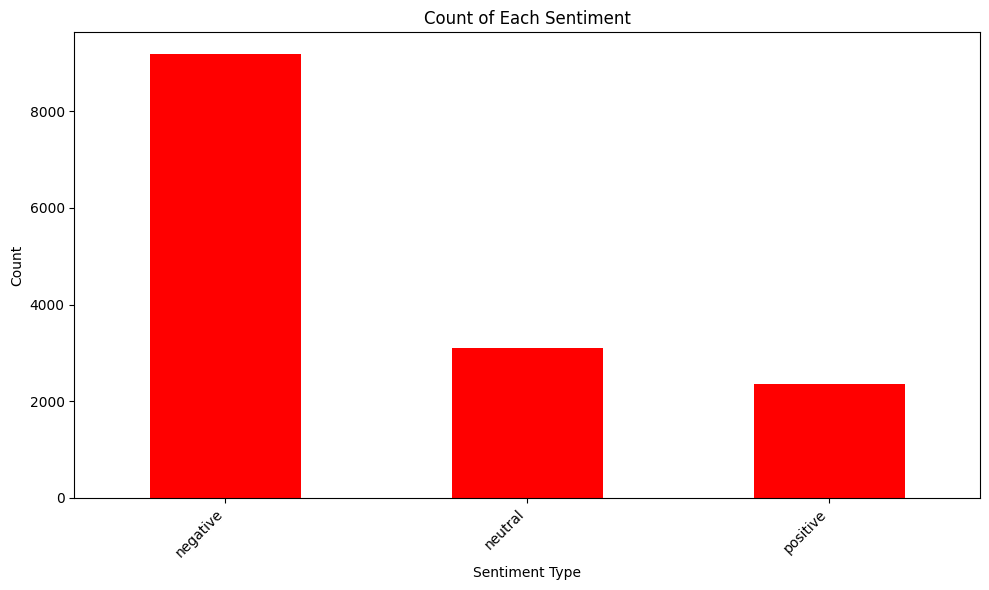

In [10]:
Sentiment_counts = df['airline_sentiment'].value_counts()

# Plotting the bar graph
plt.figure(figsize=(10, 6))
Sentiment_counts.plot(kind='bar', color='red')
plt.title('Count of Each Sentiment')
plt.xlabel('Sentiment Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


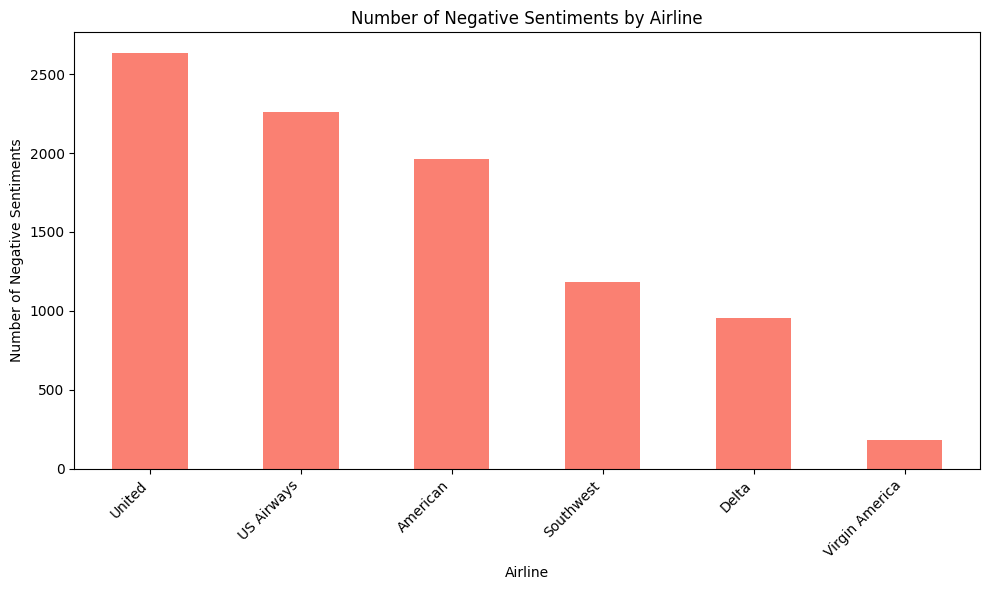

In [12]:
negative_df = df[df['airline_sentiment'] == 'negative']

#
negative_counts = negative_df['airline'].value_counts()

# Plotting the bar graph
plt.figure(figsize=(10, 6))
negative_counts.plot(kind='bar', color='salmon')
plt.title('Number of Negative Sentiments by Airline')
plt.xlabel('Airline')
plt.ylabel('Number of Negative Sentiments')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

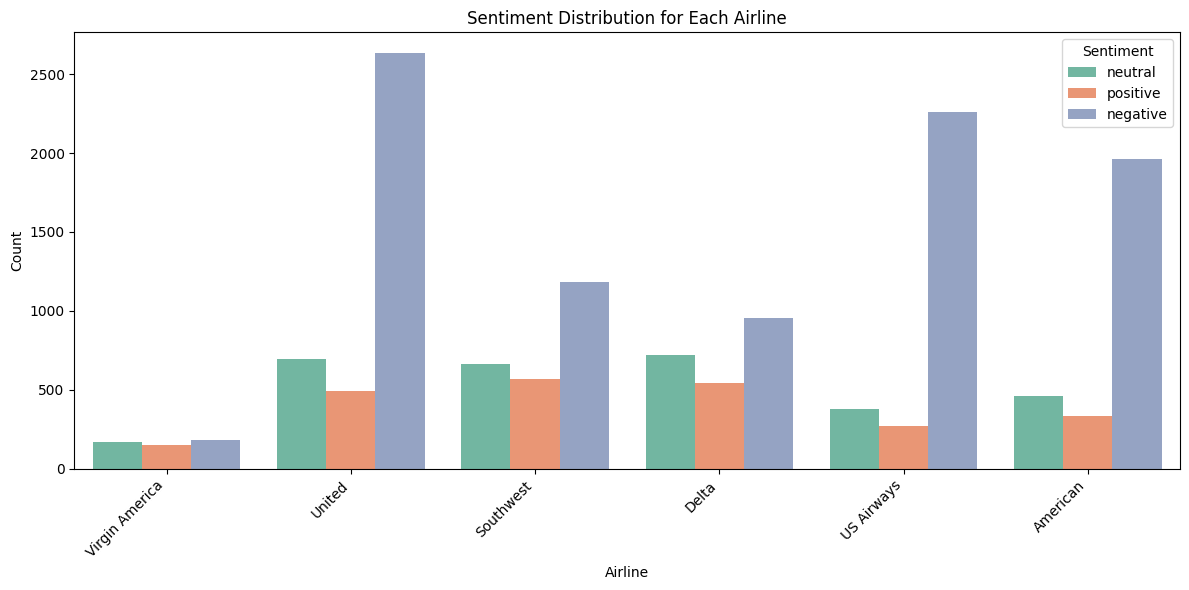

In [13]:
plt.figure(figsize=(12, 6))
sns.countplot(x='airline', hue='airline_sentiment', data=df, palette='Set2')
plt.title('Sentiment Distribution for Each Airline')
plt.xlabel('Airline')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment', loc='upper right')
plt.tight_layout()
plt.show()

In [ ]:
le = LabelEncoder()
df['airline'] = le.fit_transform(df['airline'])

df['airline_sentiment'] = le.fit_transform(df['airline_sentiment'])

# Neutral: 0; Posiitve: 1; negative: 2

In [ ]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,1,1.0000,NaN,NaN,5,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,EST
1,570301130888122368,2,0.3486,NaN,0.0000,5,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,1,0.6837,NaN,NaN,5,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,0,1.0000,Bad Flight,0.7033,5,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,0,1.0000,Can't Tell,1.0000,5,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
df = df.drop(columns=['tweet_id', 'negativereason', 'airline_sentiment_gold', 'negativereason_gold', 'tweet_coord',	'tweet_created',	'tweet_location', 'name' ])

In [ ]:
df.head()

,airline_sentiment,airline_sentiment_confidence,negativereason_confidence,airline,retweet_count,text,user_timezone
0,1,1.0000,NaN,5,0,@VirginAmerica What @dhepburn said.,EST
1,2,0.3486,0.0000,5,0,@VirginAmerica plus you've added commercials t...,Pacific Time (US & Canada)
2,1,0.6837,NaN,5,0,@VirginAmerica I didn't today... Must mean I n...,Central Time (US & Canada)
3,0,1.0000,0.7033,5,0,@VirginAmerica it's really aggressive to blast...,Pacific Time (US & Canada)
4,0,1.0000,1.0000,5,0,@VirginAmerica and it's a really big bad thing...,Pacific Time (US & Canada)


In [ ]:
df['user_timezone'] =  le.fit_transform(df['user_timezone'])

In [ ]:
df = df.dropna(subset=['user_timezone'])

In [ ]:
print(df['airline_sentiment'].isna().sum())
print(df['airline_sentiment_confidence'].isna().sum())
print(df['negativereason_confidence'].isna().sum())

0
0
4118


In [ ]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [ ]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    words = word_tokenize(text.lower())
    words = [lemmatizer.lemmatize(word) for word in words if word.isalnum()]
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

df['processed_text'] = df['text'].apply(preprocess_text)

In [ ]:
df.head()

,airline_sentiment,airline_sentiment_confidence,negativereason_confidence,airline,retweet_count,text,user_timezone,processed_text
0,1,1.0000,NaN,5,0,@VirginAmerica What @dhepburn said.,25,virginamerica dhepburn said
1,2,0.3486,0.0000,5,0,@VirginAmerica plus you've added commercials t...,56,virginamerica plus added commercial experience...
2,1,0.6837,NaN,5,0,@VirginAmerica I didn't today... Must mean I n...,22,virginamerica today must mean need take anothe...
3,0,1.0000,0.7033,5,0,@VirginAmerica it's really aggressive to blast...,56,virginamerica really aggressive blast obnoxiou...
4,0,1.0000,1.0000,5,0,@VirginAmerica and it's a really big bad thing...,56,virginamerica really big bad thing


In [ ]:
df['negativereason_confidence'].fillna(df['negativereason_confidence'].mode()[0], inplace=True)

In [ ]:
vectorizer = TfidfVectorizer()
x = vectorizer.fit_transform(df['processed_text'])

In [ ]:
df.head()

,airline_sentiment,airline_sentiment_confidence,negativereason_confidence,airline,retweet_count,text,user_timezone,processed_text
0,1,1.0000,1.0000,5,0,@VirginAmerica What @dhepburn said.,25,virginamerica dhepburn said
1,2,0.3486,0.0000,5,0,@VirginAmerica plus you've added commercials t...,56,virginamerica plus added commercial experience...
2,1,0.6837,1.0000,5,0,@VirginAmerica I didn't today... Must mean I n...,22,virginamerica today must mean need take anothe...
3,0,1.0000,0.7033,5,0,@VirginAmerica it's really aggressive to blast...,56,virginamerica really aggressive blast obnoxiou...
4,0,1.0000,1.0000,5,0,@VirginAmerica and it's a really big bad thing...,56,virginamerica really big bad thing


In [ ]:
x = x.toarray()

In [ ]:
x[22][12]

0.0

In [ ]:
x.shape

(14640, 12320)

In [ ]:
x.shape[1]

12320

In [ ]:
for i in range(x.shape[0]):
  for j in range(x.shape[1]):

    if x[i][j]!= 0:
      print(i,j)

Streaming output truncated to the last 5000 lines.
357 4521
357 5707
357 7319
357 7451
357 8274
357 8334
357 8964
357 11778
357 11785
358 2352
358 5910
358 7837
358 8752
358 8765
358 8795
358 9046
358 10172
358 11778
359 2051
359 3970
359 5319
359 5562
359 6654
359 6998
359 8541
359 9466
359 11778
360 4924
360 5707
360 6836
360 8520
360 11778
360 12171
361 2643
361 5348
361 11194
361 11778
361 11823
362 3505
362 4456
362 4735
362 7968
362 11777
362 11778
362 11779
362 12132
363 4879
363 5015
363 8012
363 10940
363 11010
363 11778
364 2759
364 3954
364 4924
364 6832
364 7489
364 7676
364 7949
364 8466
364 9810
364 9956
364 10584
364 10862
364 11778
365 1968
365 3489
365 4130
365 5707
365 7676
365 8520
365 9026
365 11778
366 559
366 739
366 2184
366 3623
366 4377
366 5910
366 8039
366 8306
366 10525
366 11661
366 11778
367 3982
367 6449
367 6654
367 8493
367 10297
367 11778
367 11820
368 1629
368 3981
368 4550
368 4924
368 5480
368 5669
368 6449
368 6654
368 8493
368 9532
368 11679
368 1

KeyboardInterrupt: 

In [ ]:
df.drop(columns=['text'], inplace=True)

In [ ]:
df.head()

,airline_sentiment,airline_sentiment_confidence,negativereason_confidence,airline,retweet_count,user_timezone,processed_text
0,1,1.0000,1.0000,5,0,25,virginamerica dhepburn said
1,2,0.3486,0.0000,5,0,56,virginamerica plus added commercial experience...
2,1,0.6837,1.0000,5,0,22,virginamerica today must mean need take anothe...
3,0,1.0000,0.7033,5,0,56,virginamerica really aggressive blast obnoxiou...
4,0,1.0000,1.0000,5,0,56,virginamerica really big bad thing


In [ ]:
df['processed_text'].isna().sum()

0

In [ ]:
Y = df.iloc[:, :1]

In [ ]:
Y = np.array(Y)

In [ ]:
Y.shape

(14640, 1)

In [ ]:
X = df.iloc[:, 1:6]
X.shape

(14640, 5)

In [ ]:
X_combined = np.concatenate((X, x), axis=1)
X_combined.shape

(14640, 12325)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_combined, Y, test_size=0.3, random_state=42)

In [ ]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [ ]:
X_train = torch.tensor(X_train)
X_test = torch.tensor(X_test)

X_val = torch.tensor(X_val)


In [ ]:
y_train = torch.tensor(y_train)
y_val = torch.tensor(y_val)
y_test = torch.tensor(y_test)

In [ ]:
X.shape

(14640, 5)

In [ ]:
X_combined.shape

(14640, 12325)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
input_size = X_train.shape[0]
hidden_size = 32
output_size = 3

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


batch_size = 32

train_dataset = CustomDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)


X_train shape: torch.Size([10248, 12325])
X_val shape: torch.Size([2196, 12325])
X_test shape: torch.Size([2196, 12325])
y_train shape: torch.Size([10248, 1])
y_val shape: torch.Size([2196, 1])
y_test shape: torch.Size([2196, 1])


In [ ]:
len(train_loader)


321

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_layer_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_layer_size= hidden_layer_size
        # self.intermediate = num_layers
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True)
        # self.lstm2 = nn.LSTM(hidden_layer_size, hidden_layer_size2, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
      batch_size = x.size(0)
      h_0 = torch.zeros(self.num_layers, batch_size, self.hidden_layer_size).to(x.device)
      c_0 = torch.zeros(self.num_layers, batch_size, self.hidden_layer_size).to(x.device)

      out, nxt = self.lstm(x, (h_0, c_0))
      out = self.fc(out[:, -1, :])

      return out


#
input_size = 12325  # Input size based on the number of features
hidden_layer_size = 64  #Hiddden size
num_layers = 4  # number of layers for lstm
output_size = 3  # Number of classes

# train_losses, train_accuracies = [], []
# val_losses = []
# val_accuracies = []
# test_losses = []
# test_accuracies = []


model = LSTM(input_size, hidden_layer_size, num_layers, output_size).to(device)


train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



In [ ]:
NUM_EPOCHS = 10
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []


for epoch in range(NUM_EPOCHS):
    # Training
    train_correct = 0
    train_total = 0
    train_loss = 0

    model.train()
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        inputs = inputs.view([inputs.shape[0], -1, input_size]).to(torch.float32)
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = F.log_softmax(outputs, dim=1)
        targets = targets.squeeze().long()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_total += targets.size(0)
        train_correct += (predicted == targets).sum().item()

    epoch_train_loss = train_loss / len(train_loader.dataset)
    epoch_train_accuracy = train_correct / train_total

    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    # Validation
    val_correct = 0
    val_total = 0
    val_loss = 0

    model.eval()
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            inputs = inputs.view([inputs.shape[0], -1, input_size]).to(torch.float32)
            outputs = model(inputs)
            outputs = F.log_softmax(outputs, dim=1)
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += targets.size(0)
            val_correct += (predicted == targets).sum().item()

        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_accuracy = val_correct / val_total

        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_accuracy)

    # Testing
    test_correct = 0
    test_total = 0
    test_loss = 0

    model.eval()
    preds_list = []
    targets_list = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            inputs = inputs.view([inputs.shape[0], -1, input_size]).to(torch.float32)
            outputs = model(inputs)
            outputs = F.log_softmax(outputs, dim=1)
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            preds_list.extend(predicted.cpu().numpy())
            targets_list.extend(targets.cpu().numpy())

            test_total += targets.size(0)
            test_correct += (predicted == targets).sum().item()

        epoch_test_loss = test_loss / len(test_loader.dataset)
        epoch_test_accuracy = test_correct / test_total

        test_losses.append(epoch_test_loss)
        test_accuracies.append(epoch_test_accuracy)

conf_matrix = confusion_matrix(targets_list, preds_list)
print("Confusion Matrix:")
print(conf_matrix)
precision = precision_score(targets_list, preds_list, average='weighted')
recall = recall_score(targets_list, preds_list, average='weighted')
f1 = f1_score(targets_list, preds_list, average='weighted')

print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))

Confusion Matrix:
[[1207  109   59]
 [ 149  229   85]
 [  62   32  264]]
Precision: 0.7689
Recall: 0.7741
F1 Score: 0.7695


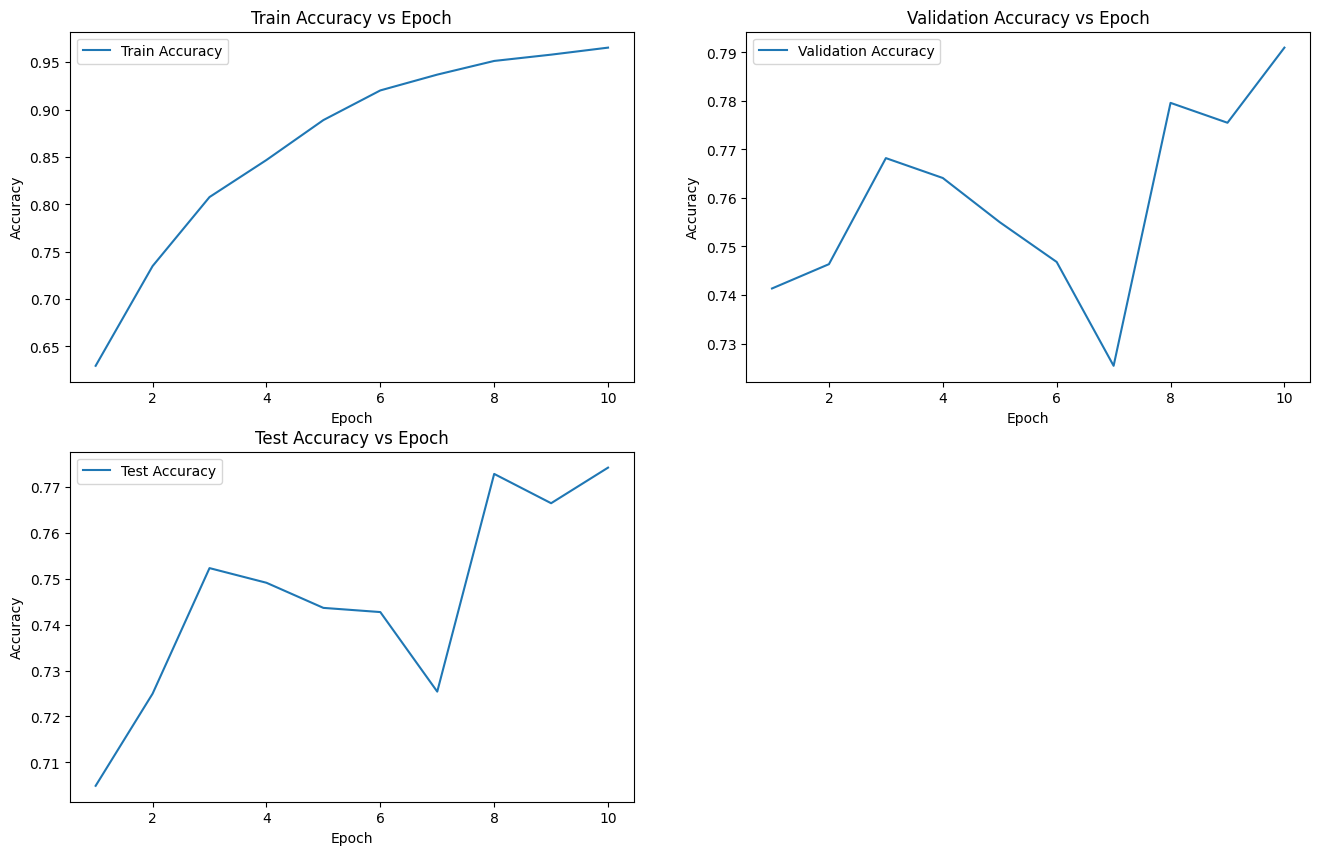

In [ ]:
plt.figure(figsize=(16, 10))
plt.subplot(2, 2, 1)
plt.plot(range(1, NUM_EPOCHS + 1), train_accuracies, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train Accuracy vs Epoch')
plt.legend()

# Plot validation accuracy
plt.subplot(2, 2, 2)
plt.plot(range(1, NUM_EPOCHS + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy vs Epoch')
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 3)
plt.plot(range(1, NUM_EPOCHS + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy vs Epoch')
plt.legend()


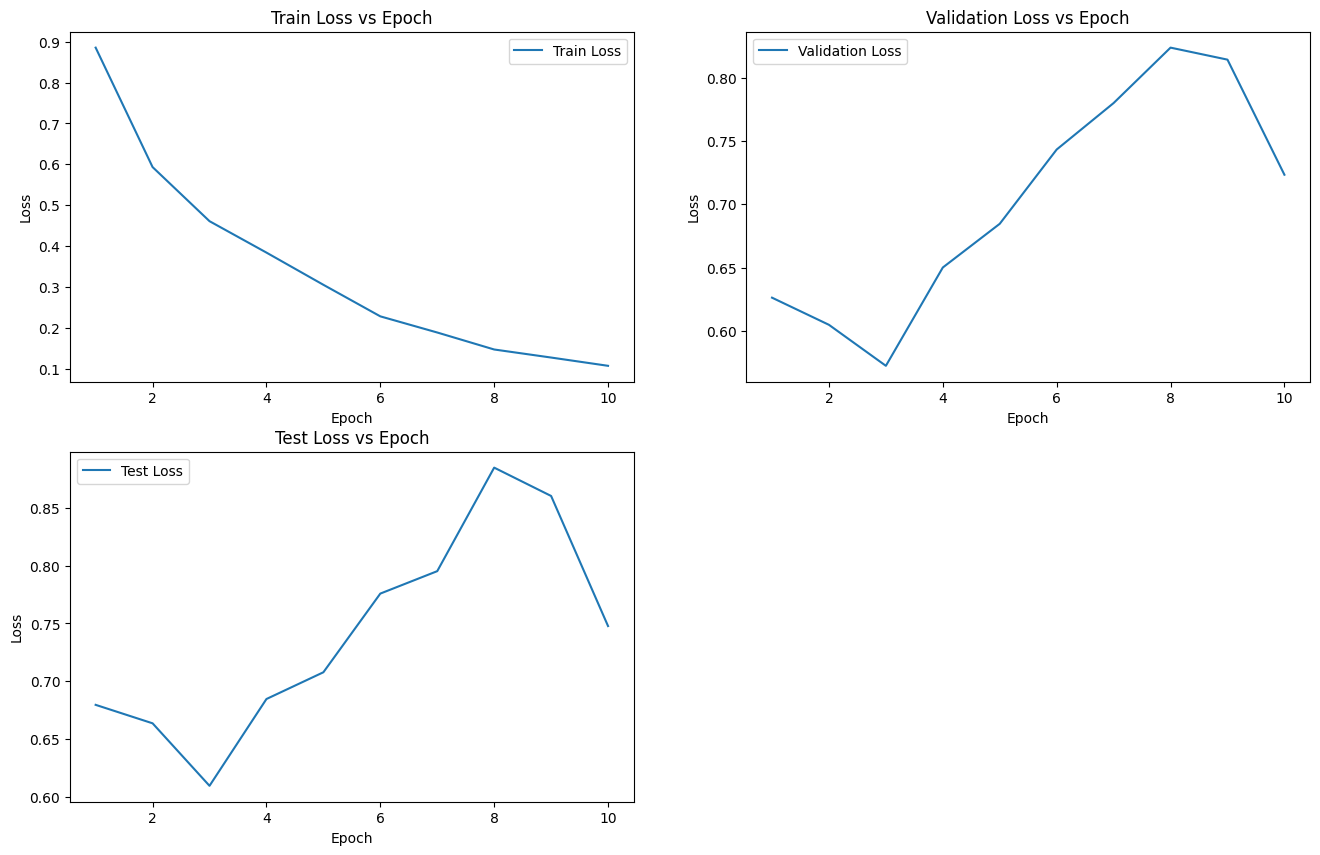

In [ ]:
# Plot train loss
plt.figure(figsize=(16, 10))
plt.subplot(2, 2, 1)
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss vs Epoch')
plt.legend()

# Plot validation loss
plt.subplot(2, 2, 2)
plt.plot(range(1, NUM_EPOCHS + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss vs Epoch')
plt.legend()

# Plot test loss
plt.subplot(2, 2, 3)
plt.plot(range(1, NUM_EPOCHS + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss vs Epoch')
plt.legend()

In [ ]:
#Print Accuracies:

print(f"Train Accuracies: {train_accuracies[-1]*100}%")
print(f"Validation Accuracies: {val_accuracies[-1]*100}%")
print(f"Test Accuracies: {test_accuracies[-1]*100}%")

Train Accuracies: 96.55542544886806%
Validation Accuracies: 79.09836065573771%
Test Accuracies: 77.41347905282332%


In [ ]:
#Print Loss:
print(f"Train Loss: {train_losses[-1]}")
print(f"Validation Loss: {val_losses[-1]}")
print(f"Test Loss: {test_losses[-1]}")

Train Loss: 0.10680879983443194
Validation Loss: 0.7234338172227959
Test Loss: 0.7477123726478258


In [ ]:
torch.save(model.state_dict(), 'lstm_basic_final.pth')

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        # self.gru2 = nn.GRU(hidden_size, hidden_size2, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, nxt = self.gru(x, h_0)
        out = self.fc(out[:, -1, :])
        return out


In [ ]:
input_size = 12325  # Number of features
hidden_size = 128
num_layers = 4
output_size = 3  # Number of classes


model = GRU(input_size, hidden_size, num_layers, output_size).to(device)


optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


NUM_EPOCHS = 4
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(NUM_EPOCHS):
    # Training
    train_correct = 0
    train_total = 0
    train_loss = 0

    model.train()
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        inputs = inputs.view([inputs.shape[0], -1, input_size]).to(torch.float32)
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = F.log_softmax(outputs, dim=1)
        targets = targets.squeeze().long()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_total += targets.size(0)
        train_correct += (predicted == targets).sum().item()

    epoch_train_loss = train_loss / len(train_loader.dataset)
    epoch_train_accuracy = train_correct / train_total

    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    # Validation
    val_correct = 0
    val_total = 0
    val_loss = 0

    model.eval()
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            inputs = inputs.view([inputs.shape[0], -1, input_size]).to(torch.float32)
            outputs = model(inputs)
            outputs = F.log_softmax(outputs, dim=1)
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += targets.size(0)
            val_correct += (predicted == targets).sum().item()

        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_accuracy = val_correct / val_total

        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_accuracy)

    # Testing
    test_correct = 0
    test_total = 0
    test_loss = 0

    model.eval()
    preds_list = []
    targets_list = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            inputs = inputs.view([inputs.shape[0], -1, input_size]).to(torch.float32)
            outputs = model(inputs)
            outputs = F.log_softmax(outputs, dim=1)
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            preds_list.extend(predicted.cpu().numpy())
            targets_list.extend(targets.cpu().numpy())

            test_total += targets.size(0)
            test_correct += (predicted == targets).sum().item()

        epoch_test_loss = test_loss / len(test_loader.dataset)
        epoch_test_accuracy = test_correct / test_total

        test_losses.append(epoch_test_loss)
        test_accuracies.append(epoch_test_accuracy)

# Compute evaluation metrics
conf_matrix = confusion_matrix(targets_list, preds_list)
precision = precision_score(targets_list, preds_list, average='weighted')
recall = recall_score(targets_list, preds_list, average='weighted')
f1 = f1_score(targets_list, preds_list, average='weighted')

# Print evaluation metrics
print("Confusion Matrix:")
print(conf_matrix)
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))


Confusion Matrix:
[[1242  115   18]
 [ 175  254   34]
 [  84   56  218]]
Precision: 0.7757
Recall: 0.7805
F1 Score: 0.7746


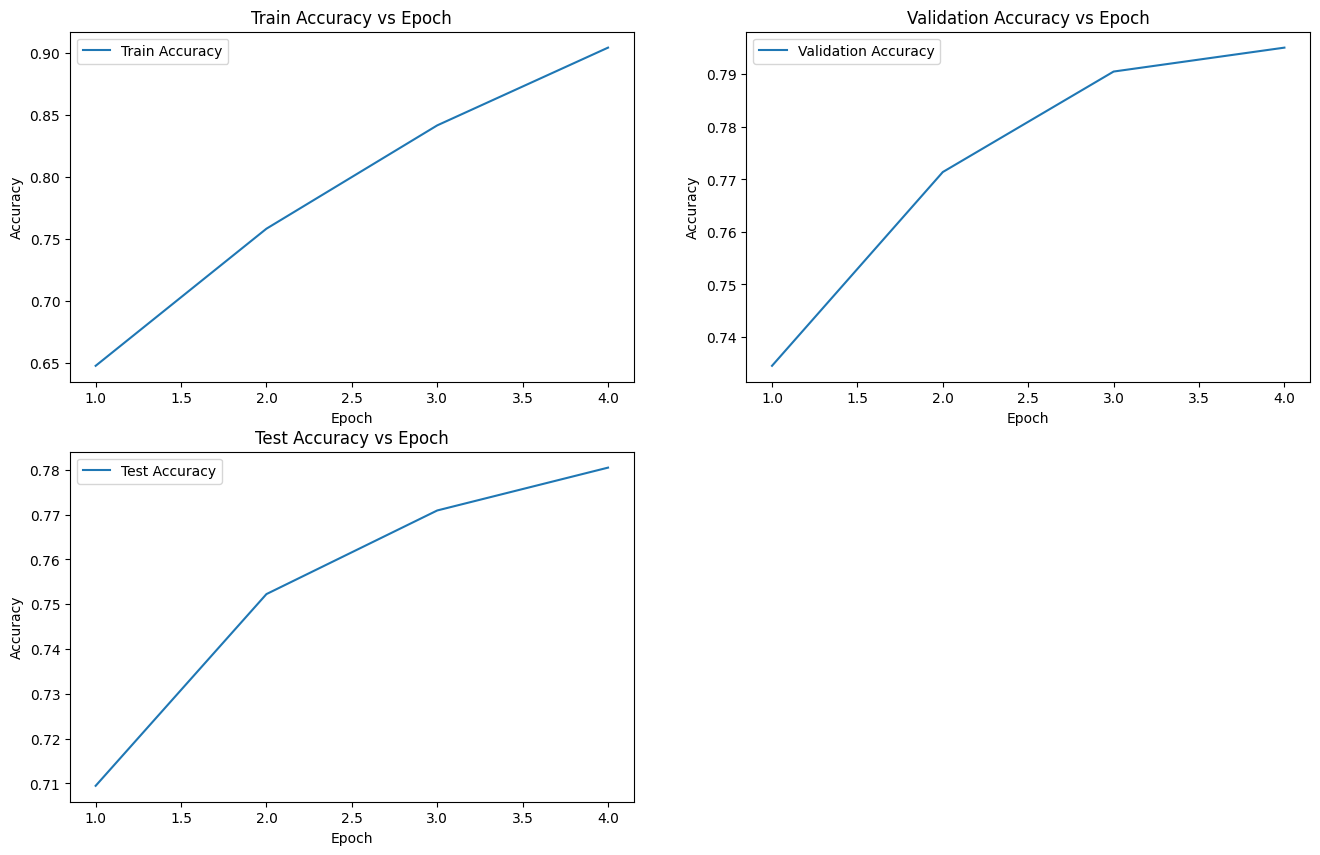

In [ ]:
plt.figure(figsize=(16, 10))
plt.subplot(2, 2, 1)
plt.plot(range(1, NUM_EPOCHS + 1), train_accuracies, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train Accuracy vs Epoch')
plt.legend()

# Plot validation accuracy
plt.subplot(2, 2, 2)
plt.plot(range(1, NUM_EPOCHS + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy vs Epoch')
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 3)
plt.plot(range(1, NUM_EPOCHS + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy vs Epoch')
plt.legend()


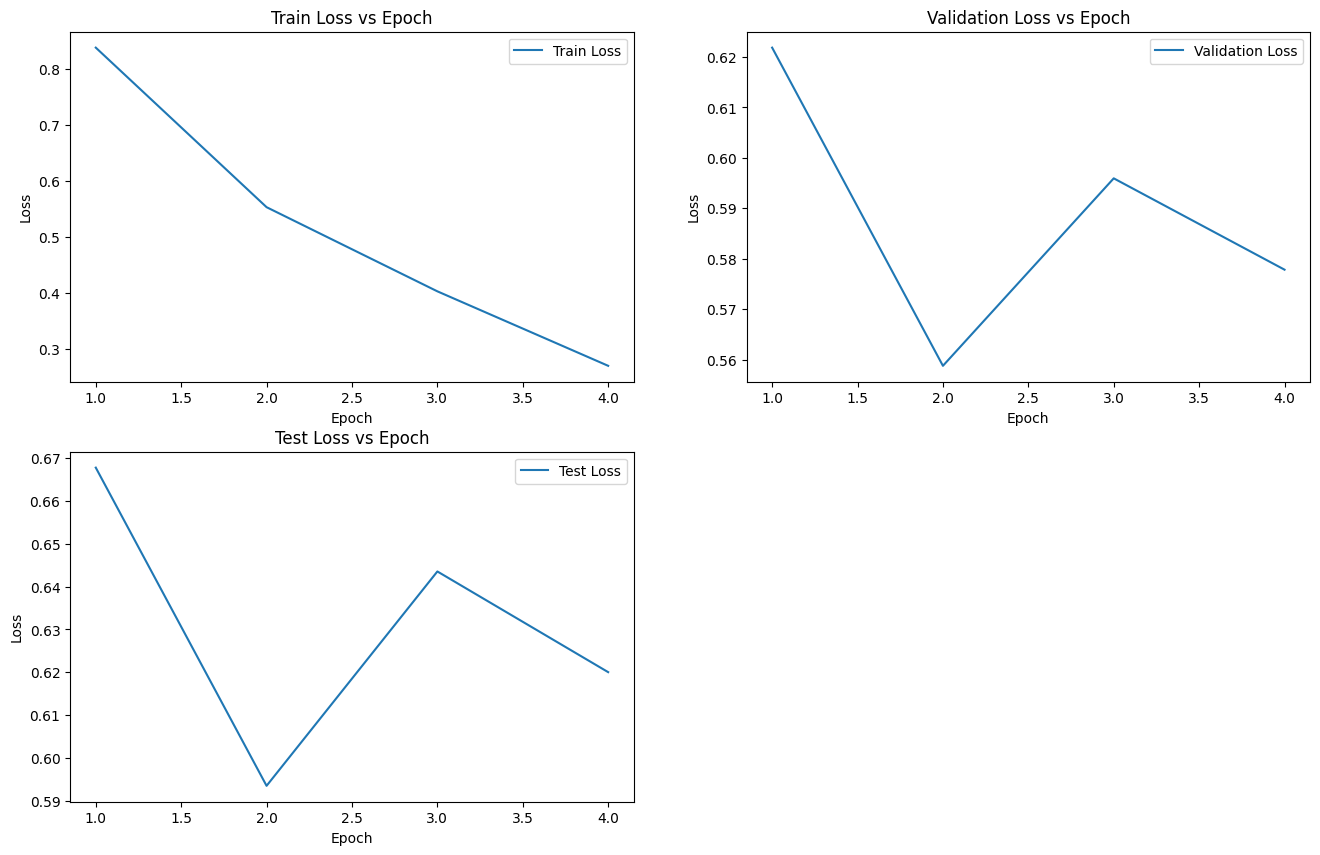

In [ ]:
# Plot train loss
plt.figure(figsize=(16, 10))
plt.subplot(2, 2, 1)
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss vs Epoch')
plt.legend()

# Plot validation loss
plt.subplot(2, 2, 2)
plt.plot(range(1, NUM_EPOCHS + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss vs Epoch')
plt.legend()

# Plot test loss
plt.subplot(2, 2, 3)
plt.plot(range(1, NUM_EPOCHS + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss vs Epoch')
plt.legend()

In [ ]:
#Print Accuracies:

print(f"Train Accuracies: {train_accuracies[-1]*100}%")
print(f"Validation Accuracies: {val_accuracies[-1]*100}%")
print(f"Test Accuracies: {test_accuracies[-1]*100}%")

Train Accuracies: 90.4566744730679%
Validation Accuracies: 79.50819672131148%
Test Accuracies: 78.05100182149363%


In [ ]:
#Print Loss:
print(f"Train Loss: {train_losses[-1]}")
print(f"Validation Loss: {val_losses[-1]}")
print(f"Test Loss: {test_losses[-1]}")

Train Loss: 0.2692724996995963
Validation Loss: 0.5778530310629061
Test Loss: 0.6200359048956297


In [ ]:
torch.save(model.state_dict(), 'gru.pth')